<a href="https://colab.research.google.com/github/TinaBhadekar/Time-series---Ridge-LSTM/blob/main/Oil_price_project_Ridgeregression_%26_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import scipy.stats
import pylab
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras


In [ ]:
stock_price_df = pd.read_csv('/content/drive/MyDrive/oilproject/Crude_All.csv')
stock_price_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-23,31.950001,32.799999,31.950001,32.049999,32.049999,79385.0
1,2000-08-24,31.900000,32.240002,31.400000,31.629999,31.629999,72978.0
2,2000-08-25,31.700001,32.099998,31.320000,32.049999,32.049999,44601.0
3,2000-08-28,32.040001,32.919998,31.860001,32.869999,32.869999,46770.0
4,2000-08-29,32.820000,33.029999,32.560001,32.720001,32.720001,49131.0
...,...,...,...,...,...,...,...
5312,2021-07-02,75.019997,75.620003,74.410004,75.160004,75.160004,377531.0
5313,2021-07-06,75.349998,76.980003,72.940002,73.370003,73.370003,714044.0
5314,2021-07-07,73.849998,74.860001,71.070000,72.199997,72.199997,607971.0
5315,2021-07-08,72.169998,73.260002,70.760002,72.940002,72.940002,529690.0


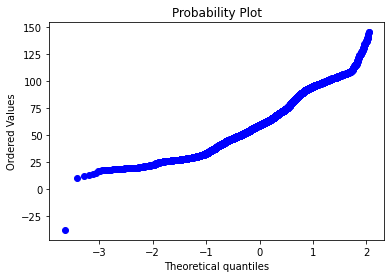

In [ ]:
scipy.stats.probplot(stock_price_df['Adj Close'],plot= pylab)
pylab.show()

In [ ]:
stock_price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-23,31.950001,32.799999,31.950001,32.049999,32.049999,79385.0
1,2000-08-24,31.900000,32.240002,31.400000,31.629999,31.629999,72978.0
2,2000-08-25,31.700001,32.099998,31.320000,32.049999,32.049999,44601.0
3,2000-08-28,32.040001,32.919998,31.860001,32.869999,32.869999,46770.0
4,2000-08-29,32.820000,33.029999,32.560001,32.720001,32.720001,49131.0


In [ ]:
stock_price_df.isna().sum()

Date           0
Open         107
High         107
Low          107
Close        107
Adj Close    107
Volume       107
dtype: int64

In [ ]:
stock_price_df = stock_price_df.fillna(method ="ffill")

In [ ]:
stock_price_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
del stock_price_df['Open'],stock_price_df['High'],stock_price_df['Low'],stock_price_df['Close']

In [ ]:
stock_price_df.describe()

,Adj Close,Volume
count,5317.000000,5.317000e+03
mean,61.556705,2.970308e+05
std,25.641608,2.220591e+05
min,-37.630001,0.000000e+00
25%,41.610001,1.075820e+05
50%,58.520000,2.538120e+05
75%,80.570000,3.973450e+05
max,145.179993,2.288230e+06


In [ ]:
stock_price_df.rename({'Adj Close':'Closing Price'}, axis= 1, inplace = True)
stock_price_df


,Date,Close,Volume
0,2000-08-23,32.049999,79385.0
1,2000-08-24,31.629999,72978.0
2,2000-08-25,32.049999,44601.0
3,2000-08-28,32.869999,46770.0
4,2000-08-29,32.720001,49131.0
...,...,...,...
5312,2021-07-02,75.160004,377531.0
5313,2021-07-06,73.370003,714044.0
5314,2021-07-07,72.199997,607971.0
5315,2021-07-08,72.940002,529690.0


In [ ]:
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] =x[i]/x[i][0]
  return x

In [ ]:
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name = i)
  fig.show()

In [ ]:
interactive_plot(normalize(stock_price_df),'Normalised Price and Volume')

In [ ]:
def trading_window(data):
  n =1
  data['Target'] = data[['Close']].shift(-n)
  return data

In [ ]:
price_volume_target_df = trading_window(stock_price_df)
price_volume_target_df

,Date,Close,Volume,Target
0,2000-08-23,32.049999,79385.0,31.629999
1,2000-08-24,31.629999,72978.0,32.049999
2,2000-08-25,32.049999,44601.0,32.869999
3,2000-08-28,32.869999,46770.0,32.720001
4,2000-08-29,32.720001,49131.0,33.400002
...,...,...,...,...
5312,2021-07-02,75.160004,377531.0,73.370003
5313,2021-07-06,73.370003,714044.0,72.199997
5314,2021-07-07,72.199997,607971.0,72.940002
5315,2021-07-08,72.940002,529690.0,74.559998


In [ ]:
price_volume_target_df = price_volume_target_df[:-1]
price_volume_target_df

,Date,Close,Volume,Target
0,2000-08-23,32.049999,79385.0,31.629999
1,2000-08-24,31.629999,72978.0,32.049999
2,2000-08-25,32.049999,44601.0,32.869999
3,2000-08-28,32.869999,46770.0,32.720001
4,2000-08-29,32.720001,49131.0,33.400002
...,...,...,...,...
5311,2021-07-01,75.230003,615678.0,75.160004
5312,2021-07-02,75.160004,377531.0,73.370003
5313,2021-07-06,73.370003,714044.0,72.199997
5314,2021-07-07,72.199997,607971.0,72.940002


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
price_volume_target_scaled_df = sc.fit_transform(price_volume_target_df.drop(columns = ['Date']))

In [ ]:
price_volume_target_scaled_df

array([[0.38116078, 0.03469275, 0.37886331],
       [0.37886331, 0.03189277, 0.38116078],
       [0.38116078, 0.01949148, 0.38564631],
       ...,
       [0.60718783, 0.3120508 , 0.60078771],
       [0.60078771, 0.26569488, 0.60483566],
       [0.60483566, 0.2314846 , 0.6136973 ]])

In [ ]:
price_volume_target_scaled_df.shape

(5316, 3)

In [ ]:
X = price_volume_target_scaled_df[:, :2]
y = price_volume_target_scaled_df[:, 2:]

In [ ]:
X.shape, y.shape

((5316, 2), (5316, 1))

In [ ]:
split = int(0.65 * len(X))
split


3455

In [ ]:
X_train = X[:split]
X_train.shape

(3455, 2)

In [ ]:
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [ ]:
X_train.shape, y_train.shape

((3455, 2), (3455, 1))

In [ ]:
X_test.shape, y_test.shape

((1861, 2), (1861, 1))

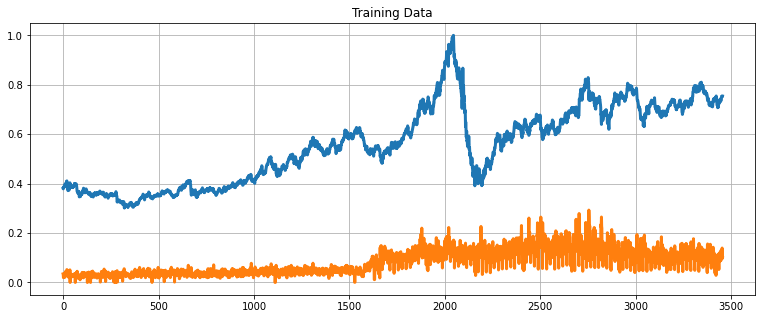

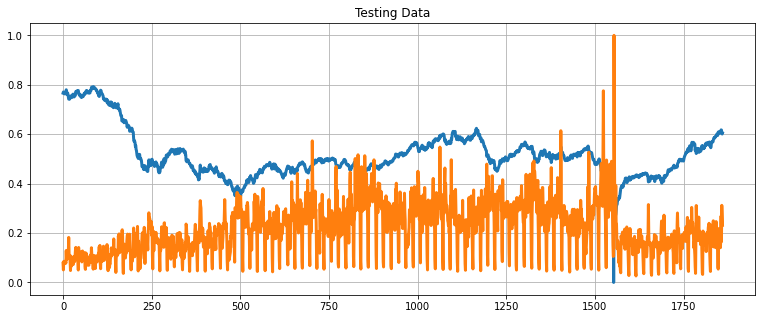

In [ ]:
def show_plot(data, title):
  plt.figure(figsize = (13, 5))
  plt.plot(data, linewidth = 3)
  plt.title(title)
  plt.grid()

show_plot(X_train, 'Training Data')
show_plot(X_test, 'Testing Data')


In [ ]:
from sklearn.linear_model import Ridge
regression_model = Ridge()
regression_model.fit(X_train, y_train)


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
lr_accuracy = regression_model.score(X_test, y_test)
print("Linear Regression Score: ", lr_accuracy)

Linear Regression Score:  0.9762425920135256


In [ ]:
predicted_prices = regression_model.predict(X)
predicted_prices

array([[0.38316862],
       [0.38079328],
       [0.38245581],
       ...,
       [0.61694536],
       [0.60852038],
       [0.61087004]])

In [ ]:
Predicted = []
for i in predicted_prices:
  Predicted.append(i[0])

In [ ]:
len(Predicted)

5316

In [ ]:
close = []
for i in price_volume_target_scaled_df:
  close.append(i[0])


In [ ]:
df_predicted = price_volume_target_df[['Date']]
df_predicted

,Date
0,2000-08-23
1,2000-08-24
2,2000-08-25
3,2000-08-28
4,2000-08-29
...,...
5311,2021-07-01
5312,2021-07-02
5313,2021-07-06
5314,2021-07-07


In [ ]:
df_predicted['Close'] = close
df_predicted

,Date,Close
0,2000-08-23,0.381161
1,2000-08-24,0.378863
2,2000-08-25,0.381161
3,2000-08-28,0.385646
4,2000-08-29,0.384826
...,...,...
5311,2021-07-01,0.617362
5312,2021-07-02,0.616979
5313,2021-07-06,0.607188
5314,2021-07-07,0.600788


In [ ]:
df_predicted['Prediction'] = Predicted
df_predicted

,Date,Close,Prediction
0,2000-08-23,0.381161,0.383169
1,2000-08-24,0.378863,0.380793
2,2000-08-25,0.381161,0.382456
3,2000-08-28,0.385646,0.386881
4,2000-08-29,0.384826,0.386128
...,...,...,...
5311,2021-07-01,0.617362,0.624868
5312,2021-07-02,0.616979,0.619613
5313,2021-07-06,0.607188,0.616945
5314,2021-07-07,0.600788,0.608520


In [ ]:
interactive_plot(df_predicted, "Original Vs. Prediction")

In [ ]:
training_data = stock_price_df.iloc[:, 1:3].values
training_data

array([[3.2049999e+01, 7.9385000e+04],
       [3.1629999e+01, 7.2978000e+04],
       [3.2049999e+01, 4.4601000e+04],
       ...,
       [7.2199997e+01, 6.0797100e+05],
       [7.2940002e+01, 5.2969000e+05],
       [7.4559998e+01, 5.2969000e+05]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_data)

In [ ]:
X = []
y = []
for i in range(1, len(stock_price_df)):
    X.append(training_set_scaled [i-1:i, 0])
    y.append(training_set_scaled [i, 0])

In [ ]:
X = np.asarray(X)
y = np.asarray(y)

In [ ]:
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((3721, 1, 1), (1595, 1, 1))

In [ ]:
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 150)            91200     
_________________________________________________________________
dropout (Dropout)            (None, 1, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 150)            180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense (Dense)                (None, 1)                 151   

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)

Epoch 1/20
93/93 [==============================] - 7s 23ms/step - loss: 0.0563 - val_loss: 0.0093
Epoch 2/20
93/93 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 1.2691e-04
Epoch 3/20
93/93 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 6.0962e-05
Epoch 4/20
93/93 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 5.8253e-05
Epoch 5/20
93/93 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 2.0683e-04
Epoch 6/20
93/93 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 6.2667e-05
Epoch 7/20
93/93 [==============================] - 1s 11ms/step - loss: 9.6315e-04 - val_loss: 5.9093e-05
Epoch 8/20
93/93 [==============================] - 1s 11ms/step - loss: 7.4618e-04 - val_loss: 1.9687e-04
Epoch 9/20
93/93 [==============================] - 1s 11ms/step - loss: 7.2108e-04 - val_loss: 7.3879e-05
Epoch 10/20
93/93 [==============================] - 1s 11ms/step

In [ ]:
prediction = model.predict(X)

In [ ]:
test_predicted=[]
for i in prediction:
  test_predicted.append(i[0])

In [ ]:
df_predicted = stock_price_df[1:][['Date']]

In [ ]:
df_predicted['predictions'] = test_predicted

In [ ]:
df_predicted

,Date,predictions
1,2000-08-24,0.378192
2,2000-08-25,0.375902
3,2000-08-28,0.378192
4,2000-08-29,0.382663
5,2000-08-30,0.381846
...,...,...
5312,2021-07-02,0.611715
5313,2021-07-06,0.611341
5314,2021-07-07,0.601766
5315,2021-07-08,0.595500


In [ ]:
close = []
for i in training_set_scaled:
  close.append(i[0])

In [ ]:
df_predicted['Close'] = close[1:]

In [ ]:
df_predicted

,Date,predictions,Close
1,2000-08-24,0.378192,0.378863
2,2000-08-25,0.375902,0.381161
3,2000-08-28,0.378192,0.385646
4,2000-08-29,0.382663,0.384826
5,2000-08-30,0.381846,0.388546
...,...,...,...
5312,2021-07-02,0.611715,0.616979
5313,2021-07-06,0.611341,0.607188
5314,2021-07-07,0.601766,0.600788
5315,2021-07-08,0.595500,0.604836


In [ ]:
interactive_plot(df_predicted, "Original Vs Prediction")